In [1]:
from fastai import *
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastai.metrics import error_rate, accuracy
from torchvision.transforms import RandAugment
from torchvision.models.efficientnet import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import os
import timm
import seaborn as sns
import cv2
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

np.random.seed(42)

In [2]:
base_path = Path("/kaggle/input/dsc-logika-ui-2025")
train_path = base_path/'Train'/'Train'
test_path = base_path/'Test'/'Test'

base_path.ls()

(#3) [Path('/kaggle/input/dsc-logika-ui-2025/sample_submission.csv'),Path('/kaggle/input/dsc-logika-ui-2025/Test'),Path('/kaggle/input/dsc-logika-ui-2025/Train')]

In [3]:
class AlbumentationsTransform(Transform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

aug = A.Compose
(
    [
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(
            shift_limit=0.0625,
            scale_limit=0.1,
            rotate_limit=15,
            p=0.7
        ),
        A.RandomBrightnessContrast(p=0.8),
        A.HueSaturationValue(
            hue_shift_limit=10,
            sat_shift_limit=20,
            val_shift_limit=10,
            p=0.5
        ),
        A.CoarseDropout(
            max_holes=8,
            max_height=25,
            max_width=25,
            p=0.5
        )
    ]
)

dls_small = ImageDataLoaders.from_folder(
    train_path,
    valid_pct = 0.2,
    seed = 42,
    item_tfms = RandomResizedCrop(128, min_scale=0.75),
    batch_tfms = AlbumentationsTransform(aug)
)

dls_large = ImageDataLoaders.from_folder(
    train_path,
    valid_pct = 0.2,
    seed = 42,
    item_tfms = RandomResizedCrop(224, min_scale=0.75),
    batch_tfms = AlbumentationsTransform(aug)
)

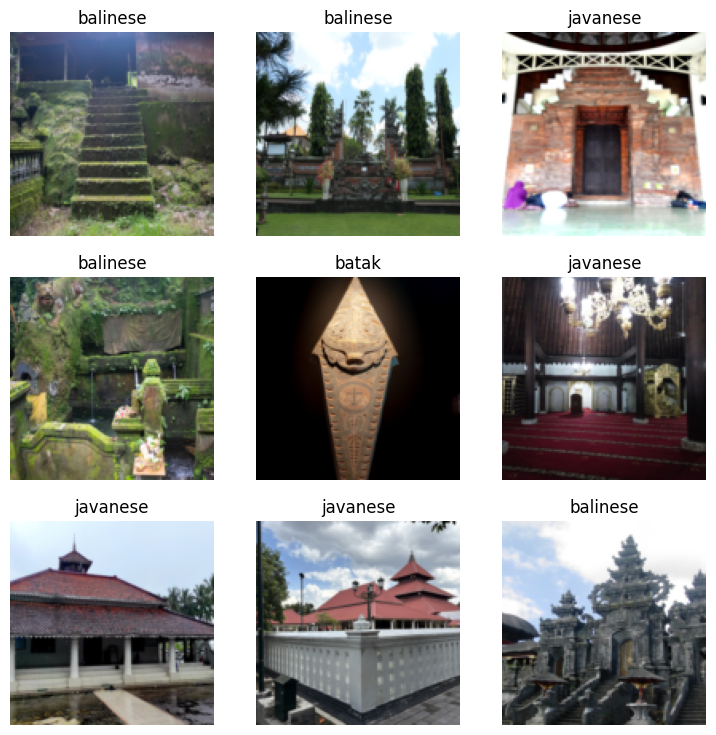

In [4]:
dls_small.show_batch(max_n=9)

In [5]:
test_files = get_image_files(test_path)
test_dl = dls_large.test_dl(test_files)

print("Classes:", dls_large.vocab)
print("Number of classes:", len(dls_large.vocab))
print("Number of training images:", len(dls_large.train_ds))
print("Number of validation images:", len(dls_large.valid_ds))

Classes: ['balinese', 'batak', 'dayak', 'javanese', 'minangkabau']
Number of classes: 5
Number of training images: 1402
Number of validation images: 350


In [6]:
model = timm.create_model('convnext_tiny.fb_in1k', pretrained=True)

learn = vision_learner(
    dls_small,
    'convnext_tiny.fb_in1k',
    metrics = F1Score(average='macro'),
    path = '/kaggle/working/'
)

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

0.00831763744354248

0.002511886414140463

0.0005754399462603033

0.0030199517495930195

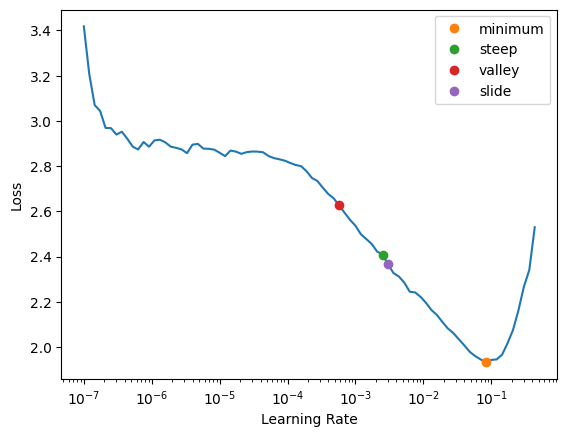

In [7]:
lrs_small = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
display(
    lrs_small.minimum,
    lrs_small.steep,
    lrs_small.valley,
    lrs_small.slide
)

In [8]:
learn.fit_one_cycle(
    15, 
    lrs_small.valley,
    cbs = [
        MixUp(0.6), 
        SaveModelCallback(monitor='f1_score')
    ]
)

epoch,train_loss,valid_loss,f1_score,time
0,2.723662,1.833558,0.234563,03:52
1,2.375687,1.363131,0.395796,03:47
2,2.145088,1.148700,0.523016,03:46
3,1.910700,1.045600,0.548884,03:44
4,1.762674,0.973207,0.552553,03:45
5,1.634313,0.919869,0.577019,03:46
6,1.509158,0.911322,0.615269,03:45
7,1.435651,0.909466,0.558374,03:47
8,1.342845,0.873756,0.599181,03:47
9,1.277826,0.832705,0.573224,03:46


Better model found at epoch 0 with f1_score value: 0.23456259370191868.
Better model found at epoch 1 with f1_score value: 0.3957955099719583.
Better model found at epoch 2 with f1_score value: 0.523015587649734.
Better model found at epoch 3 with f1_score value: 0.5488836718690135.
Better model found at epoch 4 with f1_score value: 0.5525533836172885.
Better model found at epoch 5 with f1_score value: 0.5770188101152215.
Better model found at epoch 6 with f1_score value: 0.6152690787304893.


0.0019054606556892395

6.309573450380412e-07

0.0005754399462603033

0.0030199517495930195

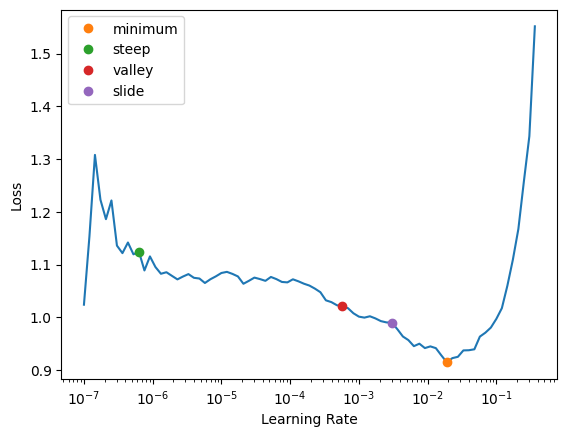

In [9]:
learn.dls = dls_large
lrs_large = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
display(
    lrs_large.minimum,
    lrs_large.steep,
    lrs_large.valley,
    lrs_large.slide
)

In [10]:
learn.unfreeze()

learn.fit_one_cycle(
    40,
    lrs_large.valley,
    cbs = [
        MixUp(0.6), 
        SaveModelCallback(monitor='f1_score')
    ]
)

epoch,train_loss,valid_loss,f1_score,time
0,1.454471,0.886907,0.524466,10:33
1,1.374229,0.867297,0.571244,10:33
2,1.293380,0.805109,0.629068,10:07
3,1.240420,0.790382,0.606431,10:02
4,1.196297,0.792404,0.672225,10:36
5,1.143176,0.811515,0.697515,10:10
6,1.111634,0.927424,0.591899,10:15
7,1.105009,0.814071,0.638986,10:16
8,1.054085,0.723241,0.684529,10:06
9,1.024971,0.805106,0.628180,10:15


Better model found at epoch 0 with f1_score value: 0.5244663088849135.
Better model found at epoch 1 with f1_score value: 0.5712439878961619.
Better model found at epoch 2 with f1_score value: 0.6290683610489518.
Better model found at epoch 4 with f1_score value: 0.6722251340342708.
Better model found at epoch 5 with f1_score value: 0.6975151010445128.
Better model found at epoch 13 with f1_score value: 0.7377573160242055.
Better model found at epoch 18 with f1_score value: 0.7379943340274522.
Better model found at epoch 23 with f1_score value: 0.7561374266029623.
Better model found at epoch 25 with f1_score value: 0.7852434838778585.


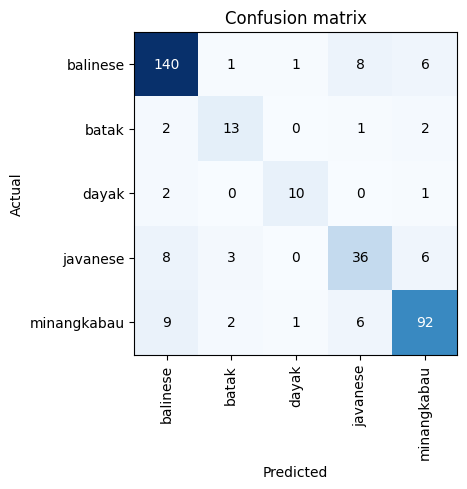

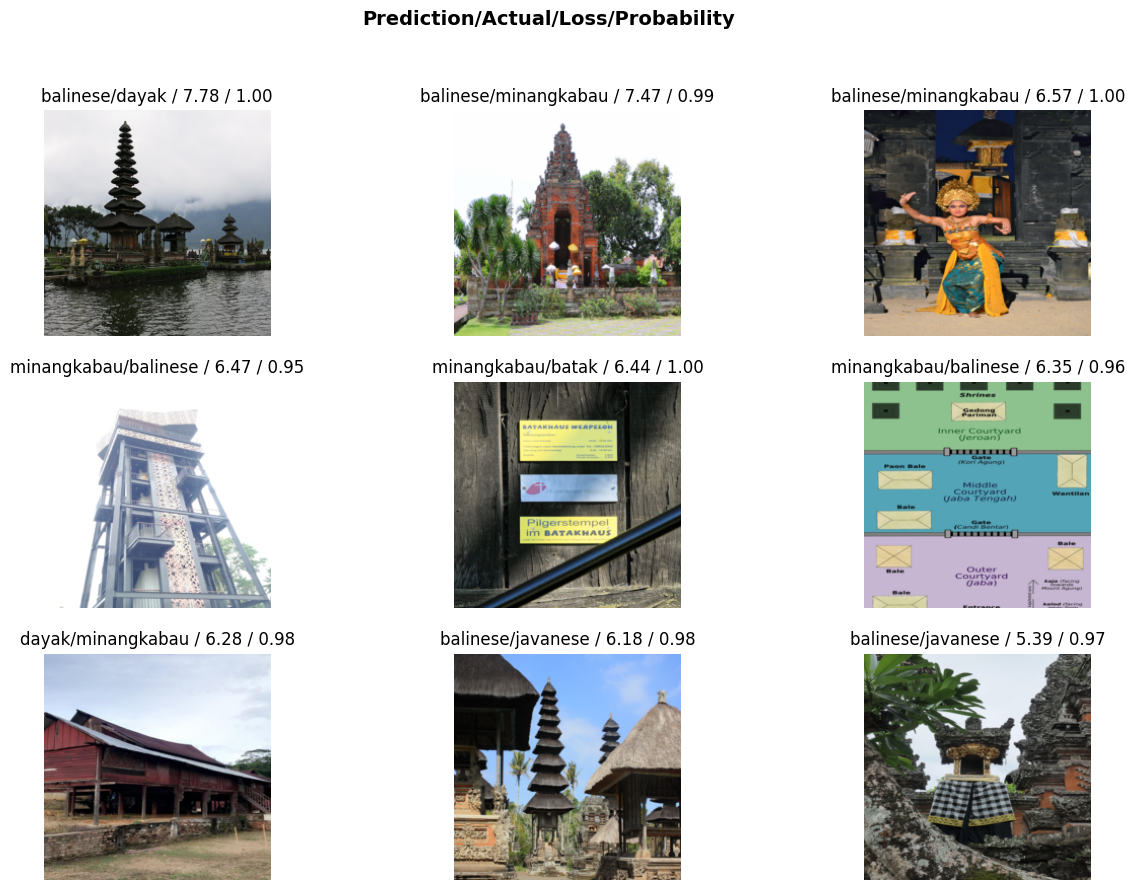

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(9, figsize=(15,10))

In [12]:
interp.print_classification_report()

              precision    recall  f1-score   support

    balinese       0.87      0.90      0.88       156
       batak       0.68      0.72      0.70        18
       dayak       0.83      0.77      0.80        13
    javanese       0.71      0.68      0.69        53
 minangkabau       0.86      0.84      0.85       110

    accuracy                           0.83       350
   macro avg       0.79      0.78      0.79       350
weighted avg       0.83      0.83      0.83       350



In [13]:
test_files = get_image_files(test_path)

preds, _ = learn.get_preds(dl=dls_large.test_dl(test_files))
pred_labels = preds.argmax(dim=1)
label_names = [dls_large.vocab[i] for i in pred_labels]

In [14]:
# Prepare submission DataFrame with correct columns: 'id' and 'style'
submission = pd.DataFrame({
    'id': [f.name[:-4] for f in test_files],
    'style': label_names
})

# Ensure the order matches sample_submission.csv if needed
sample_sub_path = train_path/'sample_submission.csv'
if sample_sub_path.exists():
    sample_sub = pd.read_csv(sample_sub_path)
    submission = submission.set_index('id').loc[sample_sub['id']].reset_index()

In [15]:
submission.sort_values('id', inplace = True)
submission['style'].value_counts()

style
balinese       208
minangkabau    138
javanese        60
batak           28
dayak           10
Name: count, dtype: int64

In [16]:
# Save to CSV
submission.to_csv('submission.csv', index=False)
print("Submission file saved as submission.csv")

Submission file saved as submission.csv
